## Init

In [1]:
import sys
import os
import yara
import yara_tools
import pandas as pd
import numpy as np
import seaborn as sns
from itertools import combinations
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import matplotlib.pyplot as plt

In [26]:
FILES_DIR = '/archive/files/nastyware-files/mix/'

In [27]:
!./pe-analyser.py --folder $FILES_DIR

Removing samples with empty imports...
Using Python version of Damicore...
Performing NCD distance matrix calculation...
Compressing individual files...
[####################] 100 %
Compressing file pairs...
[                    ]   0 %

In [4]:

lines = open('node_clustering.txt', 'r').readlines()
lines = lines[1:]

clusters = [[el.strip() for el in line.strip().split(',') if not el.strip().startswith('-')] for line in lines]

In [10]:
mostly_malware_clusters = []

for cluster in clusters:
    if len(cluster) > 1:
        malware_count = 0
        for node in cluster:
            if node.startswith('R-'):
                malware_count += 1

        # If cluster is consisted of 100% malware
        if malware_count > 0.5 * len(cluster):
            mostly_malware_clusters.append(cluster)

mostly_malware_clusters

[['R-Djvu.sample', 'G-msvcr120_clr0400.dll', 'R-Vipasana.sample'],
 ['R-File.sample', 'R-Win32.Wannacry.sample', 'R-Ransomware.sample']]

---

## Primeiro teste

In [11]:
func_dict = {}

In [12]:
def ld_data(dir_name, files, label=None):
    # Load data in files from directory dir_name in a pandas dataframe
    df = pd.DataFrame()
    for filename in files:
        funcs = []
        with open(os.path.join(dir_name, filename), 'r') as f:
            lines = f.read().splitlines()
            
            for line in lines:
                lib, func = line.split(' ')
                if '@' in func or '?' in func:
                    continue

                if not func.lower() in func_dict:
                    func_dict[func.lower()] = [(lib, func)]
                else:
                    func_dict[func.lower()].append((lib, func))

                funcs.append(func)

        # label = 'MALWARE' if filename.startswith('R') else 'GOODWARE'
        df = pd.concat([df, pd.DataFrame({'filename': filename, 'label': label, 'funcs': ' '.join(funcs)}, index=[0])], ignore_index=True)
        
    return df

In [13]:
malware_clusters_df = [ld_data(FILES_DIR, cluster, str(i)) for i, cluster in enumerate(mostly_malware_clusters)]
rest_df = ld_data(FILES_DIR, [f for f in os.listdir(FILES_DIR) if not any([f in cluster for cluster in mostly_malware_clusters])], '-1')

# Concat in rest_df all malware_clusters_df
df = pd.concat([rest_df] + malware_clusters_df, ignore_index=True)

In [14]:
df

,filename,label,funcs
0,G-mfvdsp.dll,-1,_initterm _amsg_exit __C_specific_handler _Xcp...
1,G-offlinesam.dll,-1,free _XcptFilter memset __C_specific_handler m...
2,G-BthTelemetry.dll,-1,_itoa_s strcat_s qsort strnlen realloc memcpy ...
3,G-aclui.dll,-1,_wcsnicmp _wcstoui64 _ultow_s iswctype wcstoul...
4,G-cmutil.dll,-1,__C_specific_handler _initterm malloc free _am...
...,...,...,...
177,G-msvcr120_clr0400.dll,0,EncodePointer DecodePointer RtlPcToFileHeader ...
178,R-Vipasana.sample,0,DeleteCriticalSection LeaveCriticalSection Ent...
179,R-File.sample,1,PathAppendW CreateProcessW GetSystemTime lstrl...
180,R-Win32.Wannacry.sample,1,CloseHandle WriteFile CreateFileA SizeofResour...


In [15]:
# Mudar isso para um BAG OF WORDS
vectorizer = TfidfVectorizer()
df_vectors = vectorizer.fit_transform(df['funcs']).ceil()

classifier = DecisionTreeClassifier(criterion='entropy')
classifier.fit(df_vectors, df['label'])

DecisionTreeClassifier(criterion='entropy')

/home/joao/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


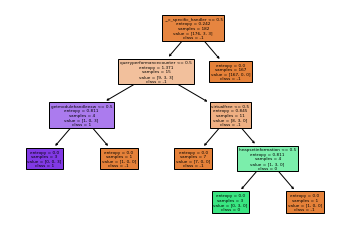

In [16]:
fn = vectorizer.get_feature_names()
cn = df['label'].unique()

plot_tree(classifier,
               feature_names = fn, 
               class_names=cn,
               filled = True);

plt.savefig('asdf.svg')

---

## Segundo teste

In [17]:
# Functions that occur in all malwares in the cluster
def plus_functions(dir, cluster):
    file_sets = []

    for file in cluster:
        file_sets.append(set(open(os.path.join(dir, file)).read().splitlines()))
    
    intersection = set.intersection(*file_sets)

    return intersection


# Functions that does not occur in any malwares in the cluster
def minus_functions(dir, cluster):
    others_set = set()

    dir = os.path.join(dir)

    for file in os.listdir(dir):
        if file in cluster:
            continue

        others_set.update(set(open(os.path.join(os.path.join(dir, file))).read().splitlines()))
    
    cluster_set = set()
    for file in cluster:
        cluster_set.update(set(open(os.path.join(dir, file)).read().splitlines()))

    others_minus_cluster = others_set - cluster_set

    return others_minus_cluster


In [21]:

plus = [plus_functions(FILES_DIR, cluster) for cluster in mostly_malware_clusters]
minus = [minus_functions(FILES_DIR, cluster) for cluster in mostly_malware_clusters]

In [24]:
[len(p) for p in plus]

[30, 0]

In [25]:
[len(m) for m in minus]

[6141, 6430]